In [190]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks, peak_prominences

In [191]:
dg_df = pd.read_csv('./big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.2/Demographics.csv')
dg_df.head(16)

,ID,Gender,HbA1c
0,13,MALE,5.7
1,1,FEMALE,5.5
2,3,FEMALE,5.9
3,4,FEMALE,6.4
4,5,FEMALE,5.7
5,2,MALE,5.6
6,6,FEMALE,5.8
7,7,FEMALE,5.3
8,8,FEMALE,5.6
9,10,FEMALE,6.0


In [192]:
###### ACC
# 가속도 벡터 magnitude 계산 함수
def calculate_mag(acc_x, acc_y, acc_z):
    acc_mag = (acc_x ** 2 + acc_y ** 2 + acc_z ** 2) ** 0.5
    return acc_mag

###### EDA
# rolling window에서 피크를 찾는 함수
def find_peaks_in_rolling_window(data, window_size):
    number_of_windows = 0
    peaks_in_window = 0
    for window_data in data.rolling(window=window_size):
        peaks, _ = find_peaks(window_data[' eda'], height=0, distance=4, prominence=0.3)
        if peaks.any():
            peaks_in_window += len(peaks)
        number_of_windows += 1
    return number_of_windows, peaks_in_window

In [193]:
# 빈 DataFrame 생성
df = pd.DataFrame(columns=[
    'calories2hr',
    'protein2hr',
    'sugar2hr',
    'carbs2hr',
    'calories8hr',
    'protein8hr',
    'sugar8hr',
    'carbs8hr',
    'calories24hr',
    'protein24hr',
    'sugar24hr',
    'carbs24hr',
    'acc_mean',
    'acc_std',
    'acc_min',
    'acc_max',
    'acc_q1g',
    'acc_q3g',
    'acc_skew',
    'eda_mean',
    'eda_std',
    'eda_min',
    'eda_max',
    'eda_q1g',
    'eda_q3g',
    'eda_skew',
    'PeakEDA',
    'PeakEDA2hr_sum',
    'PeakEDA2hr_mean',
    'hr_mean',
    'hr_std',
    'hr_min',
    'hr_max',
    'hr_q1g',
    'hr_q3g',
    'hr_skew',
    'maxHRV',
    'minHRV',
    'medianHRV',
    'meanHRV',
    'SDNN',
    'NN50',
    'pNN50',
    'RMSSD',
    'temp_mean',
    'temp_std',
    'temp_min',
    'temp_max',
    'temp_q1g',
    'temp_q3g',
    'temp_skew'
])

## Warnings

* 003 데이터셋 Food_Log에 칼럼 누락되어 있음 추가 필요 (단, time_end 칼럼은 없어야 하며, 뒷부분의 4개 칼럼은 {calorie,total_carb,sugar,protein}으로 구성됨).
* 001 데이터셋의 HR 대해서 datetime 포맷이 다름 (hr_df['datetime']=pd.to_datetime(hr_df['datetime'], format='%m/%d/%y %H:%M')).
* 012 데이터셋 Food_Log의 마지막 행에 데이터 누락됨.
    ~~~
    2020-05-11,07:00:00,,,Boost,,,,654.0,82.0,5.6,40.0,26.0,26.0
    -> 2020-05-11,07:00:00, 2020-05-11 07:00:00,,Boost,,,,654.0,82.0,5.6,40.0,26.0,26.0
    ~~~
* 013 데이터셋 Food_Log의 date와 datetime 포맷이 다름.

In [194]:
def validate_daily_dfs(daily_dfs):
    flset = set()
    accset = set()
    edaset = set()
    hrset = set()
    ibiset = set()
    tempset = set()
    for idx in range(len(daily_dfs['fl'])):
        flset = flset.union(set(daily_dfs['fl'][idx]['date'].to_list()))
    for idx in range(len(daily_dfs['acc'])):
        accset = accset.union(set(date.strftime("%Y-%m-%d") for date in daily_dfs['acc'][idx].index.date))
    for idx in range(len(daily_dfs['eda'])):
        edaset = edaset.union(set(date.strftime("%Y-%m-%d") for date in daily_dfs['eda'][idx].index.date))
    for idx in range(len(daily_dfs['hr'])):
        hrset = hrset.union(set(date.strftime("%Y-%m-%d") for date in daily_dfs['hr'][idx].index.date))
    for idx in range(len(daily_dfs['ibi'])):
        ibiset = ibiset.union(set(date.strftime("%Y-%m-%d") for date in daily_dfs['ibi'][idx].index.date))
    for idx in range(len(daily_dfs['temp'])):
        tempset = tempset.union(set(date.strftime("%Y-%m-%d") for date in daily_dfs['temp'][idx].index.date))
    ## 차집합 연산 : 하나라도 예외적인 다른 날짜가 있다면 제외시켜야 함.
    diff_set = flset ^ accset ^ edaset ^ hrset ^ ibiset ^ tempset

    if len(diff_set) > 0:
        ## diffset의 date값을 갖고 있는 daily_dfs 딕셔너리 내 value 의 리스트 원소(데이터프레임)를 제거
        if len(diff_set & flset) > 0:
            indexes_to_remove = []
            for idx in range(len(daily_dfs['fl'])):
                for date in daily_dfs['fl'][idx]['date'].to_list():
                    if date in diff_set:
                        indexes_to_remove.append(idx)
            ## 제거 대상을 제거한 리스트를 새로 할당
            daily_dfs['fl'] = [daily_dfs['fl'][i] for i in range(len(daily_dfs['fl'])) if i not in indexes_to_remove]

        if len(diff_set & accset) > 0:
            indexes_to_remove = []
            for idx in range(len(daily_dfs['acc'])):
                for date in list(date.strftime("%Y-%m-%d") for date in daily_dfs['acc'][idx].index.date):
                    if date in diff_set:
                        indexes_to_remove.append(idx)
            ## 제거 대상을 제거한 리스트를 새로 할당
            daily_dfs['acc'] = [daily_dfs['acc'][i] for i in range(len(daily_dfs['acc'])) if i not in indexes_to_remove]

        if len(diff_set & edaset) > 0:
            indexes_to_remove = []
            for idx in range(len(daily_dfs['eda'])):
                for date in list(date.strftime("%Y-%m-%d") for date in daily_dfs['eda'][idx].index.date):
                    if date in diff_set:
                        indexes_to_remove.append(idx)
            ## 제거 대상을 제거한 리스트를 새로 할당
            daily_dfs['eda'] = [daily_dfs['eda'][i] for i in range(len(daily_dfs['eda'])) if i not in indexes_to_remove]

        if len(diff_set & hrset) > 0:
            indexes_to_remove = []
            for idx in range(len(daily_dfs['hr'])):
                for date in list(date.strftime("%Y-%m-%d") for date in daily_dfs['hr'][idx].index.date):
                    if date in diff_set:
                        indexes_to_remove.append(idx)
            ## 제거 대상을 제거한 리스트를 새로 할당
            daily_dfs['hr'] = [daily_dfs['hr'][i] for i in range(len(daily_dfs['hr'])) if i not in indexes_to_remove]

        if len(diff_set & ibiset) > 0:
            indexes_to_remove = []
            for idx in range(len(daily_dfs['ibi'])):
                for date in list(date.strftime("%Y-%m-%d") for date in daily_dfs['ibi'][idx].index.date):
                    if date in diff_set:
                        indexes_to_remove.append(idx)
            ## 제거 대상을 제거한 리스트를 새로 할당
            daily_dfs['ibi'] = [daily_dfs['ibi'][i] for i in range(len(daily_dfs['ibi'])) if i not in indexes_to_remove]

        if len(diff_set & tempset) > 0:
            indexes_to_remove = []
            for idx in range(len(daily_dfs['temp'])):
                for date in list(date.strftime("%Y-%m-%d") for date in daily_dfs['temp'][idx].index.date):
                    if date in diff_set:
                        indexes_to_remove.append(idx)
            ## 제거 대상을 제거한 리스트를 새로 할당
            daily_dfs['temp'] = [daily_dfs['temp'][i] for i in range(len(daily_dfs['temp'])) if i not in indexes_to_remove]

        return False, daily_dfs
    return True, daily_dfs

In [195]:
for id in range(1, len(dg_df)+1):
    fl_df = pd.read_csv(f'./big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.2/{id:03}/Food_Log_{id:03}.csv')
    acc_df = pd.read_csv(f'./big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.2/{id:03}/ACC_{id:03}.csv')
    eda_df = pd.read_csv(f'./big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.2/{id:03}/EDA_{id:03}.csv')
    bvp_df = pd.read_csv(f'./big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.2/{id:03}/BVP_{id:03}.csv')
    hr_df = pd.read_csv(f'./big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.2/{id:03}/HR_{id:03}.csv')
    ibi_df = pd.read_csv(f'./big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.2/{id:03}/IBI_{id:03}.csv')
    temp_df = pd.read_csv(f'./big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.2/{id:03}/TEMP_{id:03}.csv')
    dexcom_df = pd.read_csv(f'./big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.2/{id:03}/Dexcom_{id:03}.csv')

    biological_sex = dg_df.loc[dg_df['ID'] == id, 'Gender'].values[0]
    hbA1c = dg_df.loc[dg_df['ID'] == id, 'HbA1c'].values[0]

    target = 0

    if hbA1c > 5.6:
        target = 1

    print(f'ID : {id} | target : {target}')
    

    ## datetime 변환
    if id == 13:
        fl_df['time_begin']=pd.to_datetime(fl_df['time_begin'], format='%m/%d/%Y %H:%M')
    else:
        fl_df['time_begin']=pd.to_datetime(fl_df['time_begin'])
    fl_df.index = pd.DatetimeIndex(fl_df["time_begin"])
    fl_df = fl_df.sort_index()

    acc_df['datetime']=pd.to_datetime(acc_df['datetime'])
    acc_resampled = acc_df.set_index('datetime').resample('5Min').first()
    #acc_resampled.index = pd.DatetimeIndex(acc_resampled["datetime"])
    #acc_resampled = acc_resampled.sort_index()

    eda_df['datetime']=pd.to_datetime(eda_df['datetime'])
    eda_resampled = eda_df.set_index('datetime').resample('5Min').first()

    if id == 1:
        hr_df['datetime']=pd.to_datetime(hr_df['datetime'], format='%m/%d/%y %H:%M')
    else:
        hr_df['datetime']=pd.to_datetime(hr_df['datetime'])
    hr_resampled = hr_df.set_index('datetime').resample('5Min').first()

    ibi_df['datetime']=pd.to_datetime(ibi_df['datetime'])
    ibi_resampled = ibi_df.set_index('datetime').resample('5Min').first().interpolate(method='time')
    ibi_resampled[' ibi'] = ibi_resampled[' ibi'] * 1000 # 초 -> 밀리초 단위로

    temp_df['datetime']=pd.to_datetime(temp_df['datetime'])
    temp_resampled = temp_df.set_index('datetime').resample('5Min').first()

    ## 날짜를 기준으로 데이터프레임을 분할하여 리스트에 저장
    daily_dfs = {'fl':[], 'acc':[], 'eda':[], 'hr':[], 'ibi':[], 'temp':[], 'bvp':[], 'dexcom':[]}
    for name, group in fl_df.groupby(fl_df['time_begin'].dt.date):
        daily_dfs['fl'].append(group)
    for name, group in acc_resampled.groupby(acc_resampled.index.date):
        daily_dfs['acc'].append(group)
    for name, group in eda_resampled.groupby(eda_resampled.index.date):
        daily_dfs['eda'].append(group)
    for name, group in hr_resampled.groupby(hr_resampled.index.date):
        daily_dfs['hr'].append(group)
    for name, group in ibi_resampled.groupby(ibi_resampled.index.date):
        daily_dfs['ibi'].append(group)
    for name, group in temp_resampled.groupby(temp_resampled.index.date):
        daily_dfs['temp'].append(group)

    isok, daily_dfs = validate_daily_dfs(daily_dfs=daily_dfs)
    if isok == False:
        print(f'daily_dfs is modified...')

    ## 날짜별 데이터프레임 features 추출
    for df_idx in range(len(daily_dfs['fl'])):
        daily_fl = daily_dfs['fl'][df_idx]
        daily_acc = daily_dfs['acc'][df_idx]
        daily_eda = daily_dfs['eda'][df_idx]
        daily_hr = daily_dfs['hr'][df_idx]
        daily_ibi = daily_dfs['ibi'][df_idx]
        daily_temp = daily_dfs['temp'][df_idx]
        
        ###### food log
        
        #if id == 13:
        #    daily_fl['date']=pd.to_datetime(daily_fl['date'], format='%m/%d/%y')
        #else:
        #    daily_fl['date']=pd.to_datetime(daily_fl['date'])

        calories2hr = 0.
        protein2hr = 0.
        sugar2hr = 0.
        carbs2hr = 0.
        calories8hr = 0.
        protein8hr = 0.
        sugar8hr = 0.
        carbs8hr = 0.
        calories24hr = 0.
        protein24hr = 0.
        sugar24hr = 0.
        carbs24hr = 0.

        for window_data in daily_fl.rolling(window='2h', on='time_begin'):
            calories2hr += window_data['calorie'].values.sum()
            protein2hr += window_data['protein'].values.sum()
            sugar2hr += window_data['sugar'].values.sum()
            carbs2hr += window_data['total_carb'].values.sum()

        for window_data in daily_fl.rolling(window='8h', on='time_begin'):
            calories8hr += window_data['calorie'].values.sum()
            protein8hr += window_data['protein'].values.sum()
            sugar8hr += window_data['sugar'].values.sum()
            carbs8hr += window_data['total_carb'].values.sum()

        for window_data in daily_fl.rolling(window='24h', on='time_begin'):
            calories24hr += window_data['calorie'].values.sum()
            protein24hr += window_data['protein'].values.sum()
            sugar24hr += window_data['sugar'].values.sum()
            carbs24hr += window_data['total_carb'].values.sum()


        ###### accelerometer
        
        daily_acc['vector_mag'] = calculate_mag(daily_acc[' acc_x'], daily_acc[' acc_y'], daily_acc[' acc_z'])

        acc_mean = daily_acc['vector_mag'].mean()
        acc_std = daily_acc['vector_mag'].std()
        acc_min = daily_acc['vector_mag'].min()
        acc_max = daily_acc['vector_mag'].max()
        acc_q1g = daily_acc['vector_mag'].quantile(0.25)
        acc_q3g = daily_acc['vector_mag'].quantile(0.75)
        acc_skew = daily_acc['vector_mag'].skew()


        ###### eda

        eda_mean = daily_eda[' eda'].mean()
        eda_std = daily_eda[' eda'].std()
        eda_min = daily_eda[' eda'].min()
        eda_max = daily_eda[' eda'].max()
        eda_q1g = daily_eda[' eda'].quantile(0.25)
        eda_q3g = daily_eda[' eda'].quantile(0.75)
        eda_skew = daily_eda[' eda'].skew()

        # peak detection
        peaks_idx, properties = find_peaks(daily_eda[' eda'], height=0, distance=4, prominence=0.3)
        peak_eda = len(peaks_idx)

        number_of_windows, peaks_in_window = find_peaks_in_rolling_window(daily_eda, window_size='2h')
        peakEDA2hr_sum = peaks_in_window
        peakEDA2hr_mean = peaks_in_window / number_of_windows


        ###### hr

        hr_mean = daily_hr[' hr'].mean()
        hr_std = daily_hr[' hr'].std()
        hr_min = daily_hr[' hr'].min()
        hr_max = daily_hr[' hr'].max()
        hr_q1g = daily_hr[' hr'].quantile(0.25)
        hr_q3g = daily_hr[' hr'].quantile(0.75)
        hr_skew = daily_hr[' hr'].skew()


        ###### ibi

        maxHRV = daily_ibi[' ibi'].max()
        minHRV = daily_ibi[' ibi'].min()
        medianHRV = daily_ibi[' ibi'].median()
        meanHRV = daily_ibi[' ibi'].mean()
        sdnn = daily_ibi[' ibi'].std()

        nn50 = 0.
        for i in range(len(daily_ibi)-1):
            if np.abs(daily_ibi.iloc[i+1][' ibi'] - daily_ibi.iloc[i][' ibi']) > 50:
                nn50 +=1

        pnn50 = nn50/len(daily_ibi)

        rmssd = 0.
        for i in range(len(daily_ibi)-1):
            rmssd = np.abs(daily_ibi.iloc[i+1][' ibi'] - daily_ibi.iloc[i][' ibi'])**2
        rmssd = np.sqrt(rmssd) / len(daily_ibi)


        ###### temp

        temp_mean = daily_temp[' temp'].mean()
        temp_std = daily_temp[' temp'].std()
        temp_min = daily_temp[' temp'].min()
        temp_max = daily_temp[' temp'].max()
        temp_q1g = daily_temp[' temp'].quantile(0.25)
        temp_q3g = daily_temp[' temp'].quantile(0.75)
        temp_skew = daily_temp[' temp'].skew()


        ## results
        print('##################################')
        print(f'calories2hr : {calories2hr}')
        print(f'protein2hr : {protein2hr}')
        print(f'sugar2hr : {sugar2hr}')
        print(f'carbs2hr : {carbs2hr}')

        print(f'calories8hr : {calories8hr}')
        print(f'protein8hr : {protein8hr}')
        print(f'sugar8hr : {sugar8hr}')
        print(f'carbs8hr : {carbs8hr}')

        print(f'calories24hr : {calories24hr}')
        print(f'protein24hr : {protein24hr}')
        print(f'sugar24hr : {sugar24hr}')
        print(f'carbs24hr : {carbs24hr}')

        print(f'acc_mean : {acc_mean}')
        print(f'acc_std : {acc_std}')
        print(f'acc_min : {acc_min}')
        print(f'acc_max : {acc_max}')
        print(f'acc_q1g : {acc_q1g}')
        print(f'acc_q3g : {acc_q3g}')
        print(f'acc_skew : {acc_skew}')

        print(f'eda_mean : {eda_mean}')
        print(f'eda_std : {eda_std}')
        print(f'eda_min : {eda_min}')
        print(f'eda_max : {eda_max}')
        print(f'eda_q1g : {eda_q1g}')
        print(f'eda_q3g : {eda_q3g}')
        print(f'eda_skew : {eda_skew}')
        print(f'PeakEDA : {peak_eda}')
        print(f'PeakEDA2hr_sum : {peakEDA2hr_sum}')
        print(f'PeakEDA2hr_mean : {peakEDA2hr_mean}')

        print(f'hr_mean : {hr_mean}')
        print(f'hr_std : {hr_std}')
        print(f'hr_min : {hr_min}')
        print(f'hr_max : {hr_max}')
        print(f'hr_q1g : {hr_q1g}')
        print(f'hr_q3g : {hr_q3g}')
        print(f'hr_skew : {hr_skew}')

        print(f'maxHRV : {maxHRV}')
        print(f'minHRV : {minHRV}')
        print(f'medianHRV : {medianHRV}')
        print(f'meanHRV : {meanHRV}')
        print(f'SDNN : {sdnn}')
        print(f'NN50 : {nn50}')
        print(f'pNN50 : {pnn50}')
        print(f'RMSSD : {rmssd}')

        print(f'temp_mean : {temp_mean}')
        print(f'temp_std : {temp_std}')
        print(f'temp_min : {temp_min}')
        print(f'temp_max : {temp_max}')
        print(f'temp_q1g : {temp_q1g}')
        print(f'temp_q3g : {temp_q3g}')
        print(f'temp_skew : {temp_skew}')
        print('##################################')

        new_record = {
            'target':target,
            'ID': id,
            'HbA1c': hbA1c,
            'Biological Sex': biological_sex,
            'calories2hr': calories2hr,
            'protein2hr': protein2hr,
            'sugar2hr': sugar2hr,
            'carbs2hr': carbs2hr,
            'calories8hr': calories8hr,
            'protein8hr': protein8hr,
            'sugar8hr': sugar8hr,
            'carbs8hr': carbs8hr,
            'calories24hr': calories24hr,
            'protein24hr': protein24hr,
            'sugar24hr': sugar24hr,
            'carbs24hr': carbs24hr,
            'acc_mean': acc_mean,
            'acc_std': acc_std,
            'acc_min': acc_min,
            'acc_max': acc_max,
            'acc_q1g': acc_q1g,
            'acc_q3g': acc_q3g,
            'acc_skew': acc_skew,
            'eda_mean': eda_mean,
            'eda_std': eda_std,
            'eda_min': eda_min,
            'eda_max': eda_max,
            'eda_q1g': eda_q1g,
            'eda_q3g': eda_q3g,
            'eda_skew': eda_skew,
            'PeakEDA': peak_eda,
            'PeakEDA2hr_sum': peakEDA2hr_sum,
            'PeakEDA2hr_mean': peakEDA2hr_mean,
            'hr_mean': hr_mean,
            'hr_std': hr_std,
            'hr_min': hr_min,
            'hr_max': hr_max,
            'hr_q1g': hr_q1g,
            'hr_q3g': hr_q3g,
            'hr_skew': hr_skew,
            'maxHRV': maxHRV,
            'minHRV': minHRV,
            'medianHRV': medianHRV,
            'meanHRV': meanHRV,
            'SDNN': sdnn,
            'NN50': nn50,
            'pNN50': pnn50,
            'RMSSD': rmssd,
            'temp_mean': temp_mean,
            'temp_std': temp_std,
            'temp_min': temp_min,
            'temp_max': temp_max,
            'temp_q1g': temp_q1g,
            'temp_q3g': temp_q3g,
            'temp_skew': temp_skew
        }

        df = pd.concat([df, pd.DataFrame([new_record])], ignore_index=True)
    

ID : 1 | target : 0
##################################
calories2hr : 1419.0
protein2hr : 141.4
sugar2hr : 83.8
carbs2hr : 87.5
calories8hr : 2331.0
protein8hr : 173.4
sugar8hr : 249.8
carbs8hr : 257.5
calories24hr : 2331.0
protein24hr : 173.4
sugar24hr : 249.8
carbs24hr : 257.5
acc_mean : 64.5143950290996
acc_std : 4.948719288685068
acc_min : 51.12729212465687
acc_max : 82.66196223173026
acc_q1g : 63.003967004423544
acc_q3g : 65.44069152118688
acc_skew : 0.9194917482505359
eda_mean : 1.0095659126213594
eda_std : 2.109498618858213
eda_min : 0.0
eda_max : 11.573714
eda_q1g : 0.14221050000000002
eda_q3g : 0.7106794999999999
eda_skew : 3.4786452856550207
PeakEDA : 9
PeakEDA2hr_sum : 209
PeakEDA2hr_mean : 2.029126213592233
hr_mean : 75.07922330097087
hr_std : 12.785017402376095
hr_min : 57.55
hr_max : 115.03
hr_q1g : 64.56
hr_q3g : 80.89
hr_skew : 0.907700954003914
maxHRV : 1140.677
minHRV : 359.3909999999999
medianHRV : 867.2269999999999
meanHRV : 872.1293431372546
SDNN : 137.6470256582548

In [196]:
df.head(30)

,calories2hr,protein2hr,sugar2hr,carbs2hr,calories8hr,protein8hr,sugar8hr,carbs8hr,calories24hr,protein24hr,...,temp_std,temp_min,temp_max,temp_q1g,temp_q3g,temp_skew,target,ID,HbA1c,Biological Sex
0,1419.0,141.4,83.8,87.5,2331.0,173.4,249.8,257.5,2331.0,173.4,...,1.487300,30.21,36.15,32.725,34.7900,-0.765630,0.0,1.0,5.5,FEMALE
1,3181.0,86.5,293.3,455.4,5505.0,175.2,417.4,663.6,7035.0,226.2,...,2.170633,28.93,36.61,31.660,35.8325,-0.462551,0.0,1.0,5.5,FEMALE
2,3560.0,183.9,183.5,330.3,8596.0,332.9,482.9,804.9,11564.0,392.1,...,2.668324,23.03,36.23,30.640,35.8575,-0.497282,0.0,1.0,5.5,FEMALE
3,2373.0,128.7,167.8,272.5,4356.0,187.2,362.8,563.5,5425.0,247.7,...,2.637059,18.51,35.79,30.830,34.8400,-1.907737,0.0,1.0,5.5,FEMALE
4,1460.1,47.3,53.2,169.4,1776.1,55.3,79.2,235.4,2931.1,89.8,...,2.336531,28.57,36.61,30.790,35.2400,0.337218,0.0,1.0,5.5,FEMALE
5,2134.5,97.3,101.8,227.4,3209.5,137.9,212.8,437.4,4851.0,191.3,...,3.219294,26.39,36.47,30.740,35.3450,-0.634540,0.0,1.0,5.5,FEMALE
6,1521.0,93.0,100.9,169.0,3185.0,127.0,296.8,442.0,3625.0,132.0,...,1.506167,28.77,36.71,33.630,36.0900,-0.936410,0.0,1.0,5.5,FEMALE
7,1393.0,44.0,144.3,274.6,3355.0,101.2,349.5,664.8,4780.0,145.1,...,2.664601,28.39,36.47,30.365,35.7100,-0.295510,0.0,1.0,5.5,FEMALE
8,3198.0,163.2,72.2,419.5,5474.0,276.2,136.0,749.1,6076.0,312.2,...,2.063152,29.59,36.31,31.385,35.2300,-0.266382,0.0,1.0,5.5,FEMALE
9,654.0,26.0,40.0,82.0,654.0,26.0,40.0,82.0,654.0,26.0,...,3.567624,25.79,36.39,29.050,35.9150,0.000796,0.0,1.0,5.5,FEMALE


In [197]:
df.to_csv(r'./features.csv', sep='\t', encoding='utf-8', header='true')

In [200]:
df['Biological Sex'] = df['Biological Sex'].map({'FEMALE': 0, 'MALE': 1})

In [204]:
df.isna().sum()

calories2hr        0
protein2hr         0
sugar2hr           0
carbs2hr           0
calories8hr        0
protein8hr         0
sugar8hr           0
carbs8hr           0
calories24hr       0
protein24hr        0
sugar24hr          0
carbs24hr          0
acc_mean           4
acc_std            4
acc_min            4
acc_max            4
acc_q1g            4
acc_q3g            4
acc_skew           4
eda_mean           4
eda_std            4
eda_min            4
eda_max            4
eda_q1g            4
eda_q3g            4
eda_skew           4
PeakEDA            0
PeakEDA2hr_sum     0
PeakEDA2hr_mean    0
hr_mean            4
hr_std             4
hr_min             4
hr_max             4
hr_q1g             4
hr_q3g             4
hr_skew            4
maxHRV             0
minHRV             0
medianHRV          0
meanHRV            0
SDNN               0
NN50               0
pNN50              0
RMSSD              0
temp_mean          4
temp_std           4
temp_min           4
temp_max     

TODO : NaN값이 나와버려서, NaN값이 있는 곳을 확인하고 처리해줘야 함.

In [198]:
import numpy as np
from sklearn.model_selection import LeaveOneGroupOut, cross_val_predict
from sklearn.ensemble import RandomForestRegressor

def calculate_feature_importance(dataframe):
    # LOPOCV를 위한 데이터셋과 그룹 인덱스 설정
    # 데이터셋을 피쳐와 타겟으로 나누기
    X = dataframe.drop(columns=['target'])  # target을 제외한 모든 열을 피쳐로 사용
    y = dataframe['target']  # target 열을 타겟으로 사용
    groups = ['001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015', '016']

    # LeaveOneGroupOut을 이용한 LOPOCV
    logo = LeaveOneGroupOut()
    model = RandomForestRegressor()

    feature_importances = []

    for train_index, test_index in logo.split(X, y, groups):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # 모델 훈련 및 예측
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)

        # 피처 중요도 계산
        feature_importances.append(model.feature_importances_)

    # 각 피처의 중요도를 평균화하여 계산
    mean_feature_importances = np.mean(feature_importances, axis=0)

    return mean_feature_importances

In [205]:
importance = calculate_feature_importance(df)
print(importance)

ValueError: Input X contains NaN.
RandomForestClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

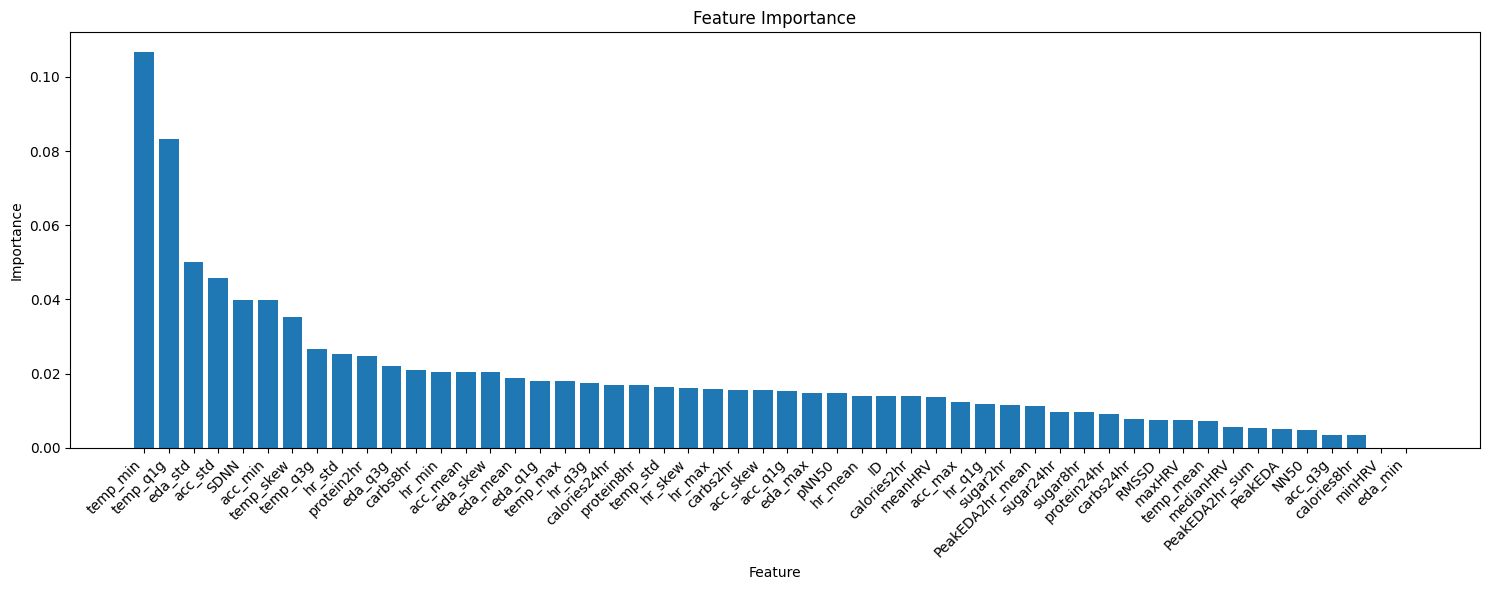

In [ ]:
import matplotlib.pyplot as plt

# 막대그래프로 중요도 출력
plt.figure(figsize=(15, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=45, ha='right')  # x축 라벨을 45도로 회전하여 가독성 높임
plt.tight_layout()  # 그래프 간격 조정
plt.show()

24시간단위로 계산안하고 한건데 잘못한 결과임